In [2]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# MPC import
import numpy as np
from LinearMPC.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [ ]:
import numpy as np
import cvxpy as cp

cases = [
    ("x-vel regulation (vx=+5 m/s)",  np.array([0, 0, 0, 0, 0, 0,  5.0, 0, 0, 0, 0, 10.0])),
    ("y-vel regulation (vy=+5 m/s)",  np.array([0, 0, 0, 0, 0, 0,  0, 5.0, 0, 0, 0, 10.0])),
    ("z-vel regulation (vz=+5 m/s)",  np.array([0, 0, 0, 0, 0, 0,  0, 0, 5.0, 0, 0, 10.0])),
    ("roll regulation (gamma=40 deg)", np.array([0, 0, 0, 0, 0, np.deg2rad(40.0),  0, 0, 0, 0, 0, 10.0])),
]

def _collect_mpc_bases(obj):
    found = []
    visited = set()

    def rec(x):
        xid = id(x)
        if xid in visited:
            return
        visited.add(xid)

        if hasattr(x, "ocp") and hasattr(x, "last_status") and hasattr(x, "get_u"):
            found.append(x)
            return

        if hasattr(x, "__dict__"):
            for v in x.__dict__.values():
                if isinstance(v, (np.ndarray, float, int, str, type(None))):
                    continue
                rec(v)

    rec(obj)
    return found

# ok=True if ALL subcontrollers returned OPTIMAL/OPTIMAL_INACCURATE when solving at t=0
def _qp_solved_for_case(Ts, H, x0, rocket_params_path):
    rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
    mpc = MPCVelControl().new_controller(rocket, Ts, H)

    rocket.simulate_control(mpc, Ts, H, x0, method="linear")

    subs = _collect_mpc_bases(mpc)

    bad = []
    for c in subs:
        st = c.last_status
        if st not in (cp.OPTIMAL, cp.OPTIMAL_INACCURATE):
            bad.append((c.__class__.__name__, st))

    return (len(bad) == 0), bad

# Find smallest integer N in N_candidates such that QP is solved for this case.
def find_min_N_for_case(Ts, N_candidates, x0, rocket_params_path, verbose=False):
    for N in N_candidates:
        H = float(N * Ts)
        ok, bad = _qp_solved_for_case(Ts, H, x0, rocket_params_path)
        if verbose:
            print(f"   N={N:3d} (H={H:.2f}) -> {ok}")
            if (not ok) and bad:
                print("      bad:", bad)
        if ok:
            return int(N), H
    return None, None

Ts = 0.05

# choose candidate N grid: H from 0.5s to 8.0s step 0.25s => N step=5
H_min_scan = 0.5
H_max_scan = 8.0
H_step_scan = 0.25

N_candidates = np.arange(
    int(np.ceil(H_min_scan / Ts)),
    int(np.floor(H_max_scan / Ts)) + 1,
    int(np.round(H_step_scan / Ts))
)
N_candidates = np.unique(N_candidates).astype(int)

print("Scanning N candidates:", N_candidates[:10], "...", N_candidates[-10:])
print()

per_case = {}
for title, x0 in cases:
    print(f"[CASE] {title}")
    N_min, H_min = find_min_N_for_case(Ts, N_candidates, x0, rocket_params_path, verbose=False)
    per_case[title] = (N_min, H_min)
    print(f"   -> N_min={N_min}, H_min={H_min}\n")

if any(v[0] is None for v in per_case.values()):
    print("At least one case never became feasible in the scan range.")
else:
    N_common = max(v[0] for v in per_case.values())
    H_common = N_common * Ts
    print("Per-case minima:")
    for k, (Nmin, Hmin) in per_case.items():
        print(f" - {k}: N_min={Nmin}, H_min={Hmin:.2f}s")
    print(f"\nCommon minimal horizon (max of per-case minima):")
    print(f" - N_min = {N_common}")
    print(f" - H_min = {H_common:.2f}s")

Scanning N candidates: [10 15 20 25 30 35 40 45 50 55] ... [115 120 125 130 135 140 145 150 155 160]

[CASE] x-vel regulation (vx=+5 m/s)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Simulating time 0.00: 
Simulating time 0.00: 
Simulating time 0.00: 
Simulating time 0.00: 
Simulating time 0.00: 
Simulating time 0.00: 
   -> N_min=35, H_min=1.75

[CASE] y-vel regulation (vy=+5 m/s)
Simulating time 0.00: 
Simulating time 0.00: 
Simulating time 0.00: 
Simulating time 0.00: 
Simulating time 0.00: 
Simulating time 0.00: 
   -> N_min=35, H_min=1.75

[CASE] z-vel regulation (vz=+5 m/s)
Simulating time 0.00: 
Simulating time 0.00: 
Simulating time 0.00: 
Si


x-vel regulation (vx=+5 m/s)
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simu

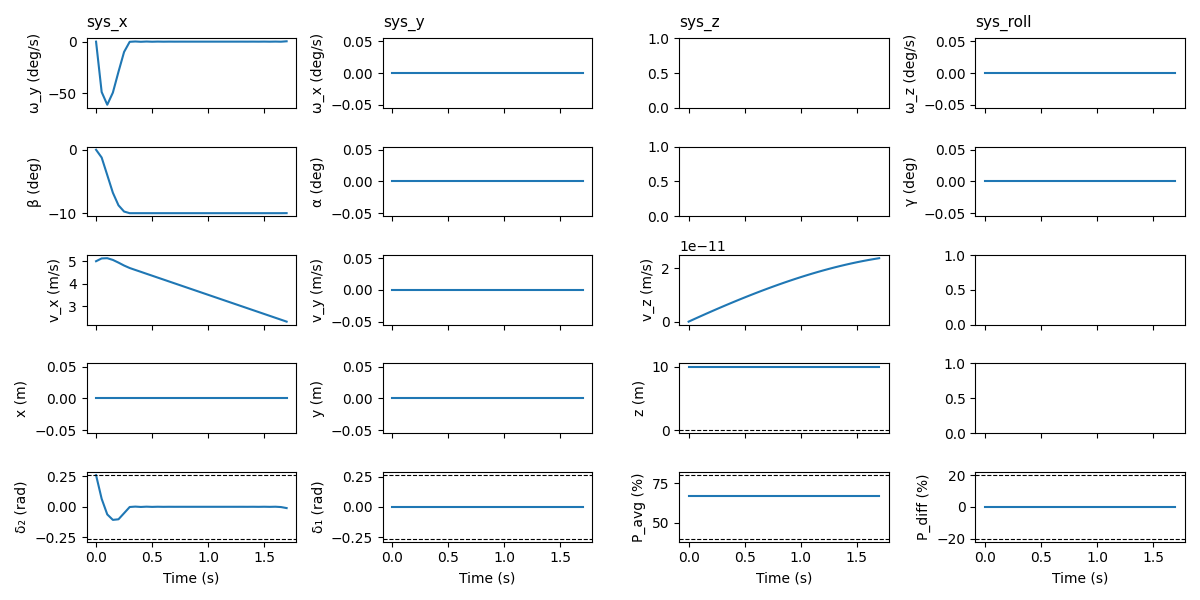




CLOSED LOOP PLOT




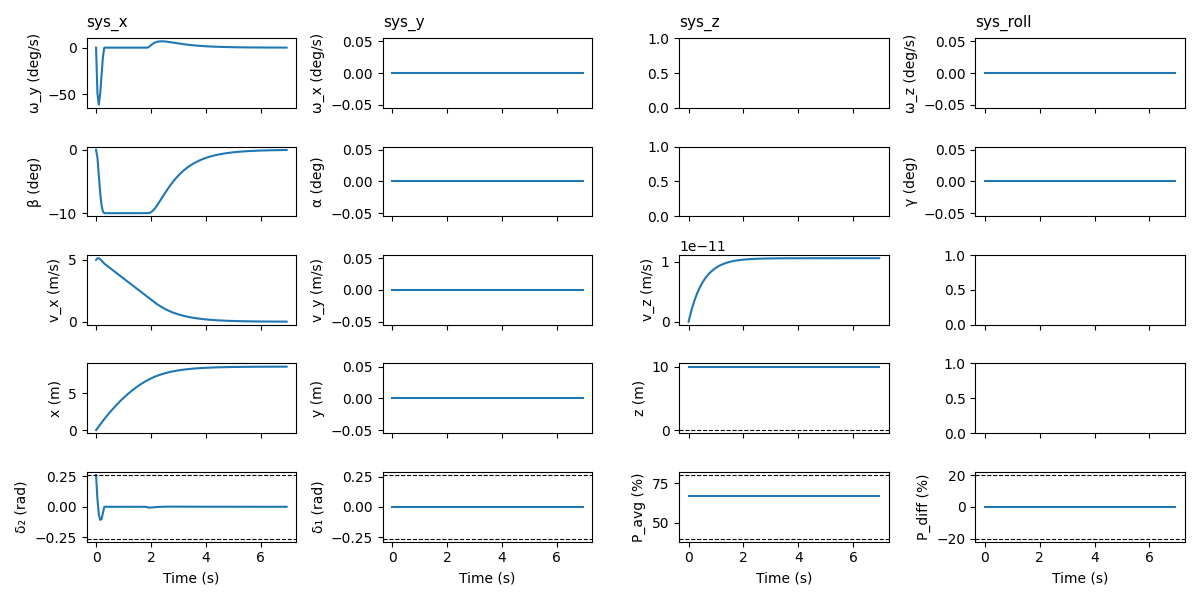

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…


y-vel regulation (vy=+5 m/s)
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simu

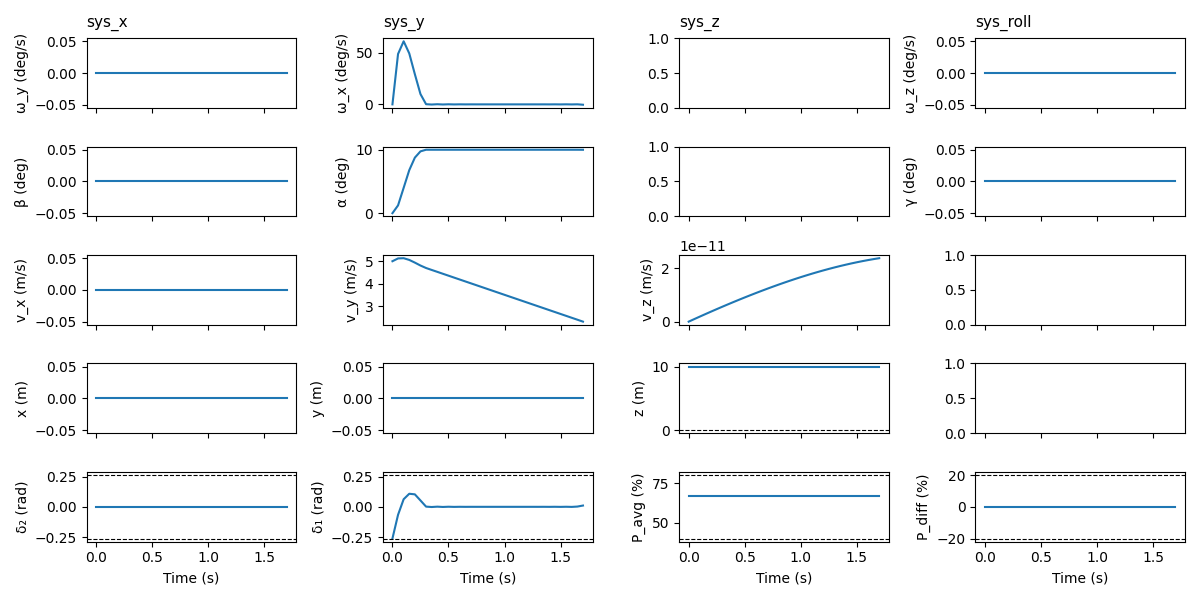




CLOSED LOOP PLOT




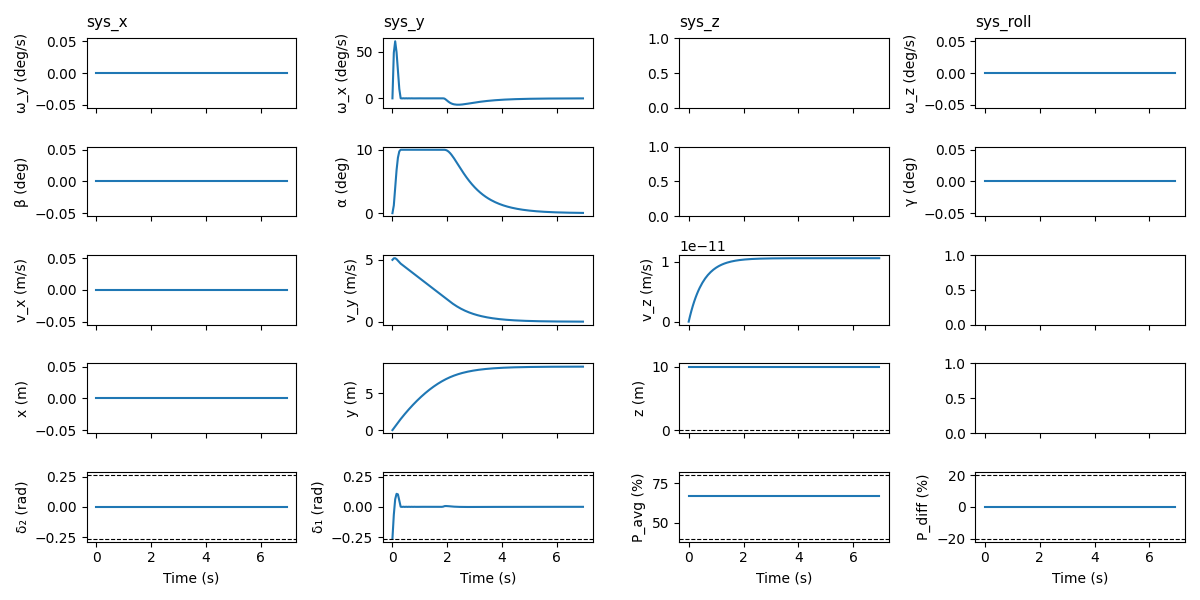

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…


z-vel regulation (vz=+5 m/s)
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simu

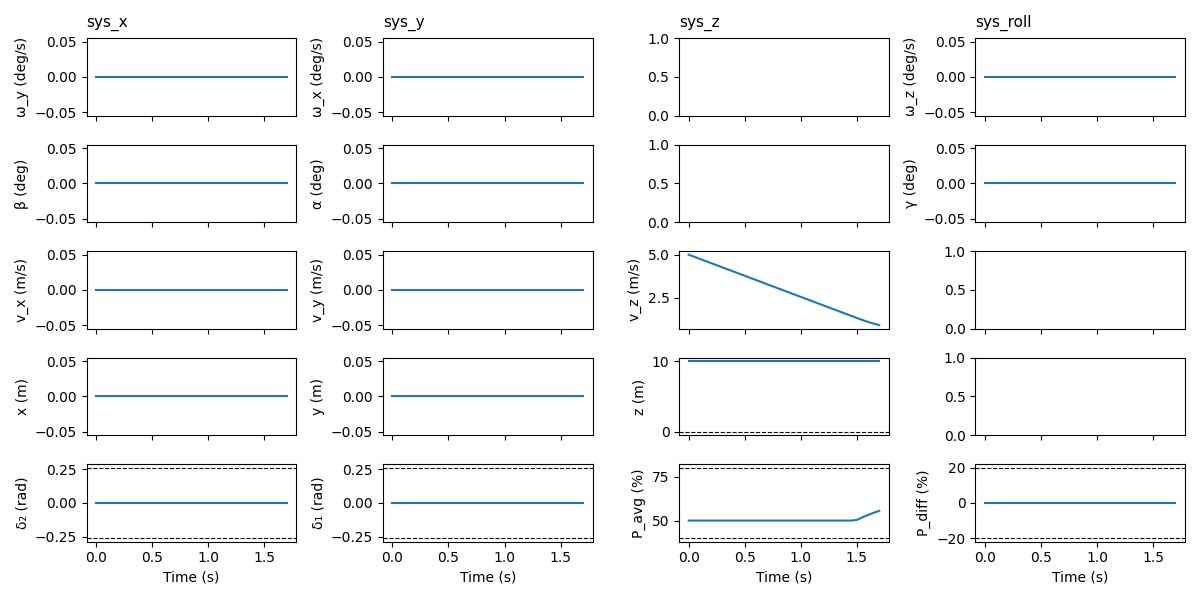




CLOSED LOOP PLOT




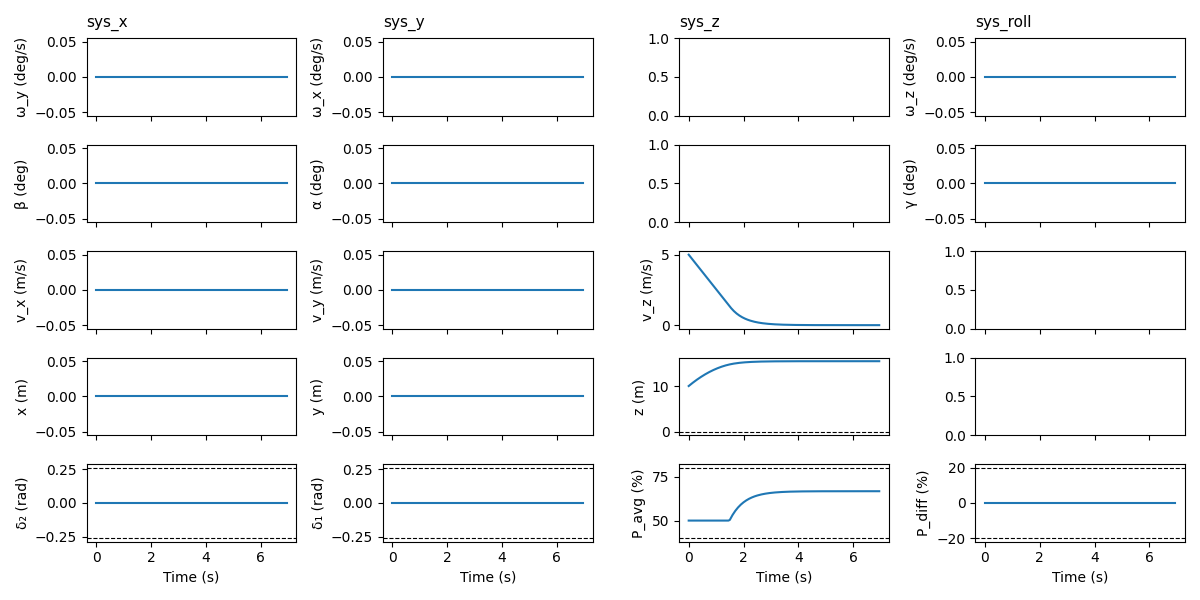

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…


roll regulation (gamma=40 deg)
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Si

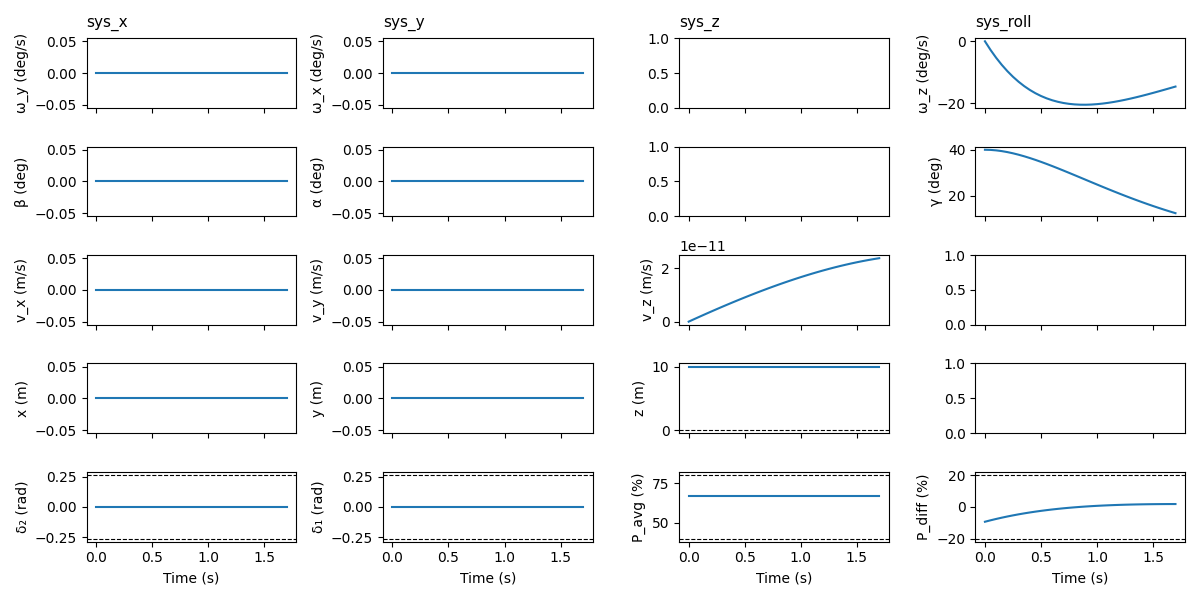




CLOSED LOOP PLOT




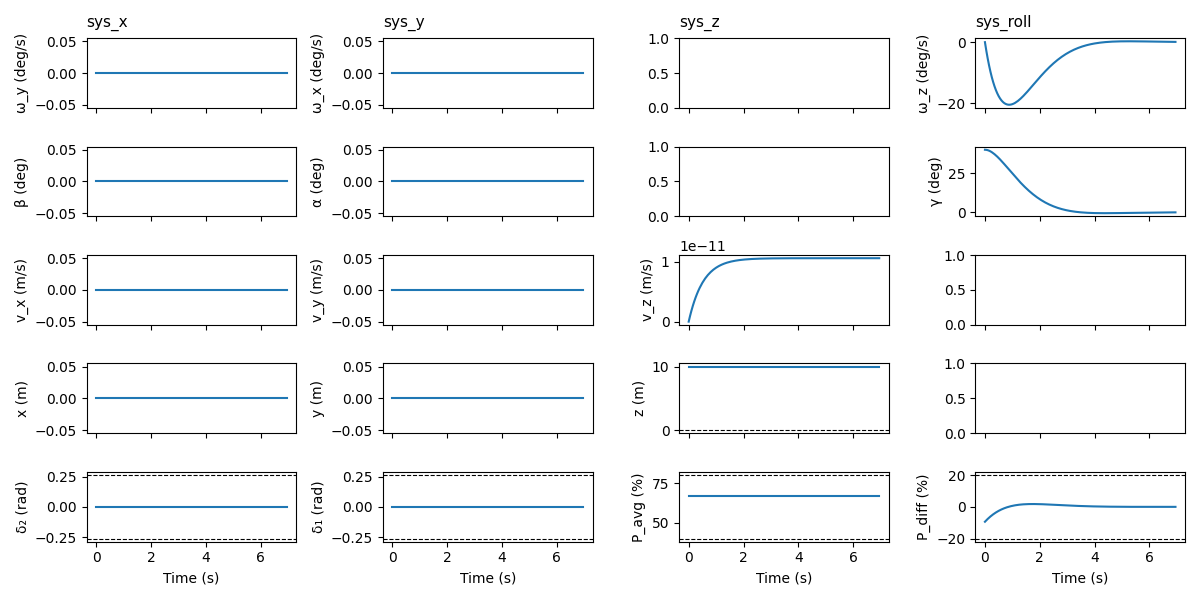

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

In [ ]:
Ts = 0.05
H = 1.75
sim_time = 7.0

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

cases = [
    ("x-vel regulation (vx=+5 m/s)",  np.array([0, 0, 0, 0, 0, 0,  5.0, 0, 0, 0, 0, 10.0])),
    ("y-vel regulation (vy=+5 m/s)",  np.array([0, 0, 0, 0, 0, 0,  0, 5.0, 0, 0, 0, 10.0])),
    ("z-vel regulation (vz=+5 m/s)",  np.array([0, 0, 0, 0, 0, 0,  0, 0, 5.0, 0, 0, 10.0])),
    ("roll regulation (gamma=40 deg)", np.array([0, 0, 0, 0, 0, np.deg2rad(40.0),  0, 0, 0, 0, 0, 10.0])),
]


for title, x0 in cases:
    print("\n" + "="*80)
    print(title)

    t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
        mpc, sim_time, H, x0, method="linear"
    )

    from src.vel_rocket_vis import plot_static_states_inputs
    u0, x_ol_0, u_ol_0, t_ol_0 = mpc.get_u(0.0, x0)
    print("\n" * 3)
    print("OPEN LOOP PLOT")
    print("\n")
    plot_static_states_inputs(t_ol_0[:-1], x_ol_0[:, :-1], u_ol_0)
    print("\n" * 2)
    print("CLOSED LOOP PLOT")
    print("\n")
    plot_static_states_inputs(t_cl[:-1], x_cl[:, :-1], u_cl)

    # Animation of closed-loop with all open-loop predictions
    vis = RocketVis(rocket, rocket_obj_path)
    vis.anim_rate = 1.0
    vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, 
                T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol)

Plotting terminal set for subsystem X


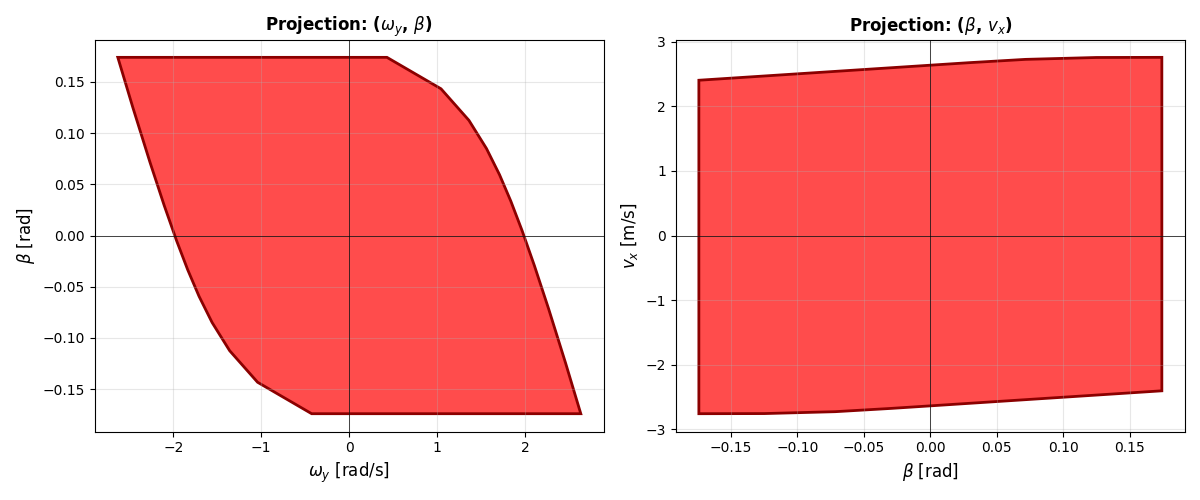

Plotting terminal set for subsystem Y


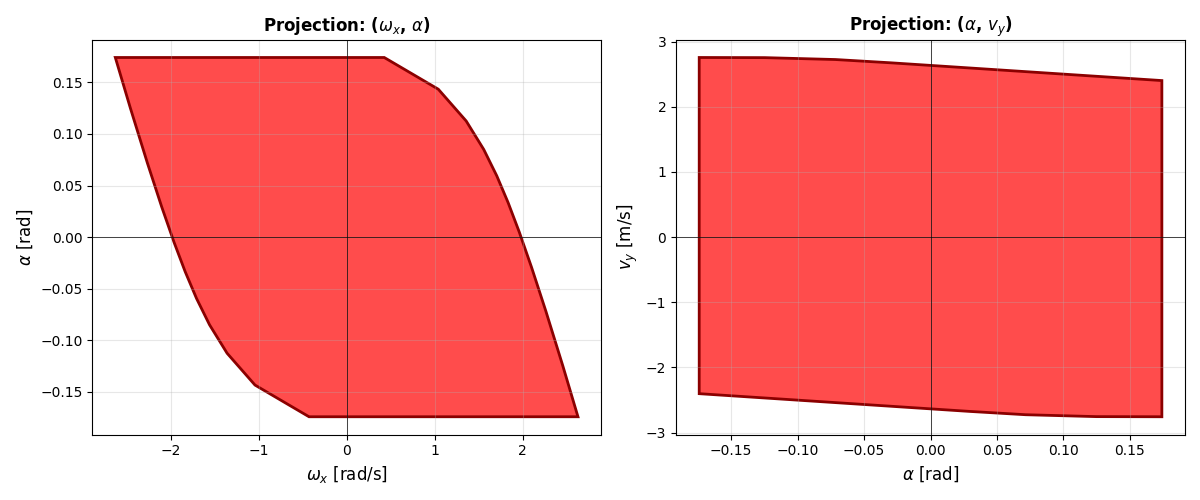

Plotting terminal set for subsystem Z.


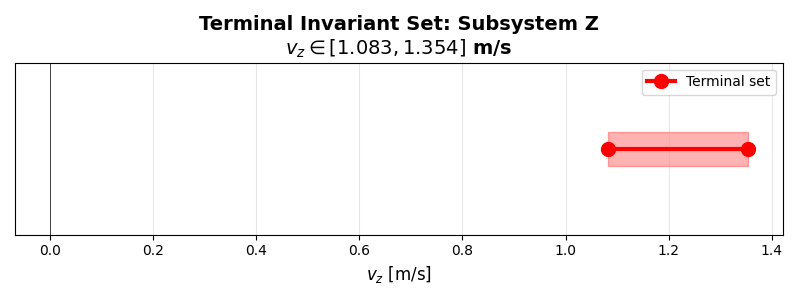

Plotting terminal set for subsystem Roll


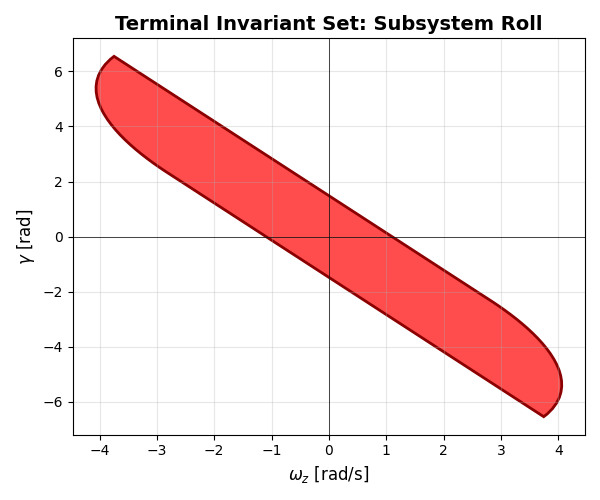

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

print("Plotting terminal set for subsystem X")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Projection (ωy, β)
mpc.mpc_x.Xf.projection(dims=(0, 1)).plot(ax=axes[0], color='red', opacity=0.7, show_edges=True, edge_width=2, edge_color='darkred')
axes[0].set_xlabel('$\\omega_y$ [rad/s]', fontsize=12)
axes[0].set_ylabel('$\\beta$ [rad]', fontsize=12)
axes[0].set_title('Projection: ($\\omega_y$, $\\beta$)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axvline(0, color='black', linewidth=0.5)

# Projection (β, vx)
mpc.mpc_x.Xf.projection(dims=(1, 2)).plot(ax=axes[1], color='red', opacity=0.7, show_edges=True, edge_width=2, edge_color='darkred')
axes[1].set_xlabel('$\\beta$ [rad]', fontsize=12)
axes[1].set_ylabel('$v_x$ [m/s]', fontsize=12)
axes[1].set_title('Projection: ($\\beta$, $v_x$)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

print("Plotting terminal set for subsystem Y")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Projection (ωx, α)
mpc.mpc_y.Xf.projection(dims=(0, 1)).plot(ax=axes[0], color='red', opacity=0.7, show_edges=True, edge_width=2, edge_color='darkred')
axes[0].set_xlabel('$\\omega_x$ [rad/s]', fontsize=12)
axes[0].set_ylabel('$\\alpha$ [rad]', fontsize=12)
axes[0].set_title('Projection: ($\\omega_x$, $\\alpha$)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axvline(0, color='black', linewidth=0.5)

# Projection (α, vy)
mpc.mpc_y.Xf.projection(dims=(1, 2)).plot(ax=axes[1], color='red', opacity=0.7, show_edges=True, edge_width=2, edge_color='darkred')
axes[1].set_xlabel('$\\alpha$ [rad]', fontsize=12)
axes[1].set_ylabel('$v_y$ [m/s]', fontsize=12)
axes[1].set_title('Projection: ($\\alpha$, $v_y$)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

print("Plotting terminal set for subsystem Z.")

A_z = mpc.mpc_z.Af
b_z = mpc.mpc_z.bf

vz_max = np.inf
vz_min = -np.inf

for i in range(len(b_z)):
    if A_z[i, 0] > 0: 
        vz_max = min(vz_max, b_z[i] / A_z[i, 0])
    elif A_z[i, 0] < 0:  
        vz_min = max(vz_min, -b_z[i] / A_z[i, 0])

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot([vz_min, vz_max], [0, 0], 'ro-', linewidth=3, markersize=10, label='Terminal set')
ax.fill_between([vz_min, vz_max], -0.1, 0.1, color='red', alpha=0.3)
ax.set_xlabel('$v_z$ [m/s]', fontsize=12)
ax.set_ylim([-0.5, 0.5])
ax.set_title(f'Terminal Invariant Set: Subsystem Z\n$v_z \\in [{vz_min:.3f}, {vz_max:.3f}]$ m/s', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_yticks([])
ax.legend()

plt.tight_layout()
plt.show()

print("Plotting terminal set for subsystem Roll")
fig, ax = plt.subplots(figsize=(6, 5))

mpc.mpc_roll.Xf.plot(ax=ax, color='red', opacity=0.7, show_edges=True, edge_width=2, edge_color='darkred')
ax.set_xlabel('$\\omega_z$ [rad/s]', fontsize=12)
ax.set_ylabel('$\\gamma$ [rad]', fontsize=12)
ax.set_title('Terminal Invariant Set: Subsystem Roll', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()